# Predictive Analytics on Household Income Dataset

This notebook demonstrates predictive analytics techniques on a household dataset to predict income levels based on various demographic and socioeconomic features.

![Household Income](https://drive.google.com/uc?id=1gZTQ5qjEf6KBGMHwSXQtBWrKCZYWdvM4)

We'll implement and compare two different machine learning algorithms: **Decision Trees** and **XGBoost** (using GradientBoostingRegressor from scikit-learn)

Through feature engineering, selection, and hyperparameter tuning, we'll determine which model delivers the best performance for predicting household income.

This household dataset can be found on [Kaggle.com](https://www.kaggle.com/datasets/stealthtechnologies/regression-dataset-for-household-income-analysis/data)

**Modeling approach:**

1. Preprocessed data with scaling and one-hot encoding
2. Applied polynomial feature engineering (degree 2)
3. Used recursive feature elimination for feature selection
4. Trained and tuned two regression models
5. Evaluated models using RMSE and R¬≤

## Data Loading and Exploration


In [1]:
# Import libraries for data manipulation and analysis

import numpy as np                    # For numerical operations
import pandas as pd                   # For data manipulation and dataframes
import matplotlib.pyplot as plt       # For creating visualizations
import seaborn as sns                 # For statistical visualizations

# Import sklearn modules for preprocessing and modeling

from sklearn.linear_model import LinearRegression                   # For linear regression
from sklearn.model_selection import train_test_split, GridSearchCV  # For data splitting and tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder     # For feature scaling and encoding
from sklearn.compose import ColumnTransformer                       # For applying different transforms
from sklearn.pipeline import Pipeline                               # For chaining operations

# Import feature engineering and selection modules

from sklearn.preprocessing import PolynomialFeatures        # For creating polynomial features
from sklearn.feature_selection import RFECV                 # For recursive feature elimination

# Import Regression Models

from sklearn.linear_model import LinearRegression           # Model 1: Linear Regression
from sklearn.tree import DecisionTreeRegressor              # Model 2: Decision Tree
from sklearn.ensemble import GradientBoostingRegressor      # Model 3: XGBoost-equivalent

# Import Evaluation Metrics

from sklearn.metrics import mean_squared_error, r2_score    # For model evaluation
import math                                                 # For mathematical operations

In [2]:
# Set visualization style

plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

In [4]:
# Load the household income data

df = pd.read_csv('data.csv')

In [5]:
# Display the first few rows of the dataset

print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


Age Education_Level  Occupation  Number_of_Dependents Location  \
0   56        Master's  Technology                     5    Urban   
1   69     High School     Finance                     0    Urban   
2   46      Bachelor's  Technology                     1    Urban   
3   32     High School      Others                     2    Urban   
4   60      Bachelor's     Finance                     3    Urban   

   Work_Experience Marital_Status Employment_Status  Household_Size  \
0               21        Married         Full-time               7   
1                4         Single         Full-time               7   
2                1         Single         Full-time               7   
3               32        Married         Full-time               1   
4               15        Married     Self-employed               4   

  Homeownership_Status     Type_of_Housing  Gender  \
0                  Own           Apartment    Male   
1                  Own           Apartment    Male   
2                  Own  Single-family home  Female   
3                  Own           Apartment  Female   
4                  Own           Townhouse    Male   

  Primary_Mode_of_Transportation  Income  
0                 Public transit   72510  
1                         Biking   75462  
2                            Car   71748  
3                            Car   74520  
4                        Walking  640210

In [6]:
# Get basic information about the dataset

print("\nBasic dataset information:")
print(f"Number of records: {df.shape[0]}")                # Print number of rows
print(f"Number of features: {df.shape[1]}")               # Print number of columns


Basic dataset information:
Number of records: 10000
Number of features: 14


In [7]:
# Check data types and missing values

print("\nDataset info:")
df.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             10000 non-null  int64 
 1   Education_Level                 10000 non-null  object
 2   Occupation                      10000 non-null  object
 3   Number_of_Dependents            10000 non-null  int64 
 4   Location                        10000 non-null  object
 5   Work_Experience                 10000 non-null  int64 
 6   Marital_Status                  10000 non-null  object
 7   Employment_Status               10000 non-null  object
 8   Household_Size                  10000 non-null  int64 
 9   Homeownership_Status            10000 non-null  object
 10  Type_of_Housing                 10000 non-null  object
 11  Gender                          10000 non-null  object
 12  Primary_Mode_of_Transportation  

In [8]:
# View statistical summary of numerical features

print("\nSummary statistics:")
display(df.describe())


Summary statistics:


Age  Number_of_Dependents  Work_Experience  Household_Size  \
count  10000.000000          10000.000000     10000.000000    10000.000000   
mean      44.021700              2.527000        24.858800        3.989600   
std       15.203998              1.713991        14.652622        2.010496   
min       18.000000              0.000000         0.000000        1.000000   
25%       31.000000              1.000000        12.000000        2.000000   
50%       44.000000              3.000000        25.000000        4.000000   
75%       57.000000              4.000000        37.000000        6.000000   
max       70.000000              5.000000        50.000000        7.000000   

             Income  
count  1.000000e+04  
mean   8.168382e+05  
std    1.821089e+06  
min    3.104400e+04  
25%    6.844600e+04  
50%    7.294300e+04  
75%    3.506675e+05  
max    9.992571e+06

## Data Preprocessing

Before building predictive models, we need to clean and prepare our data. This includes handling categorical variables, addressing missing values, detecting outliers, and preparing features for modeling.

In [9]:
# Check for missing values

missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
Age                               0
Education_Level                   0
Occupation                        0
Number_of_Dependents              0
Location                          0
Work_Experience                   0
Marital_Status                    0
Employment_Status                 0
Household_Size                    0
Homeownership_Status              0
Type_of_Housing                   0
Gender                            0
Primary_Mode_of_Transportation    0
Income                            0
dtype: int64


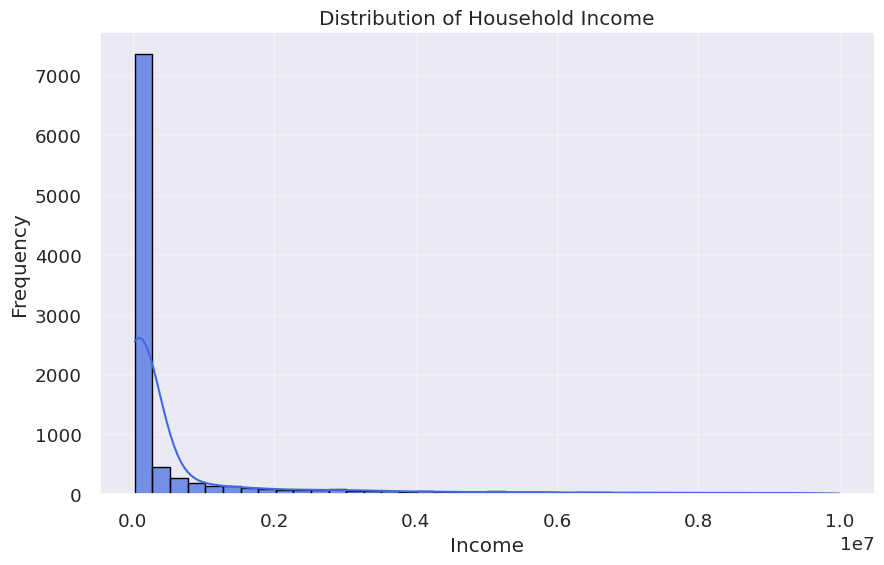

In [10]:
# Explore the distribution of the target variable (Income)

plt.figure(figsize=(10, 6))

# Better color and edge contrast
sns.histplot(df['Income'], bins=40, kde=True, color='royalblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Household Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

**Distribution of Household Income**

A right-skewed distribution showing most incomes are concentrated at the lower end, with a long tail extending toward higher values. The sharp peak at the lower income range suggests a high frequency of lower-income households, while fewer households have significantly higher incomes. The Kernel Density Estimate (KDE) line further illustrates this imbalance. This pattern is common in income distributions, where a small percentage of people earn substantially more than the majority.

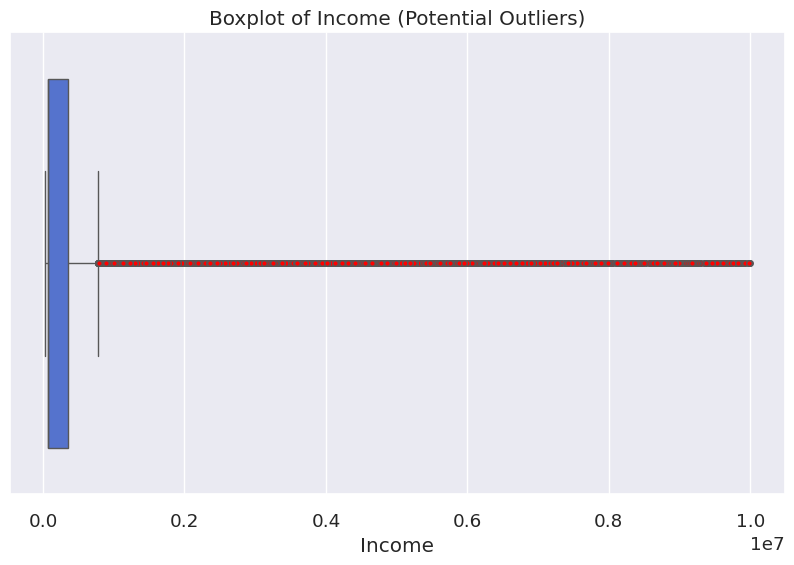

In [11]:
# Identify Outliers in Income Per Household

plt.figure(figsize=(10, 6))

sns.boxplot(x=df['Income'], color='royalblue', flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 4})

plt.title('Boxplot of Income (Potential Outliers)')
plt.xlabel('Income')

plt.show()

**Income Outliers**

The boxplot reveals a highly skewed distribution of household income, with a significant number of outliers at the higher end. The whiskers indicate the interquartile range (IQR), while red markers represent extreme values beyond 1.5√óIQR. The clustering of outliers suggests that a small proportion of households earn disproportionately higher incomes. This aligns with typical income inequality patterns, where most earn low-to-moderate incomes, and a few have extreme wealth.

In [12]:
# Extreme Outliers in Income

Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

In [13]:
# Define Outlier Thresholds

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

In [14]:
# Filter Extreme Outliers

df_filtered = df[(df['Income'] >= lower_bound) &
                (df['Income'] <= upper_bound)].copy()

In [15]:
# Compare original and filtered dataset sizes

print(f"Original dataset size: {df.shape[0]} records")
print(f"Filtered dataset size: {df_filtered.shape[0]} records")
print(f"Removed {df.shape[0] - df_filtered.shape[0]} outliers")

Original dataset size: 10000 records
Filtered dataset size: 8363 records
Removed 1637 outliers


In [16]:
# Identify categorical variables

cat_features = df_filtered.select_dtypes(include=['object']).columns.tolist()
num_features = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

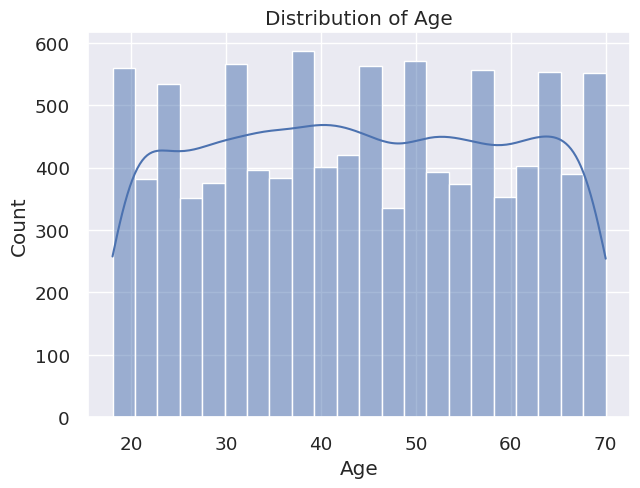

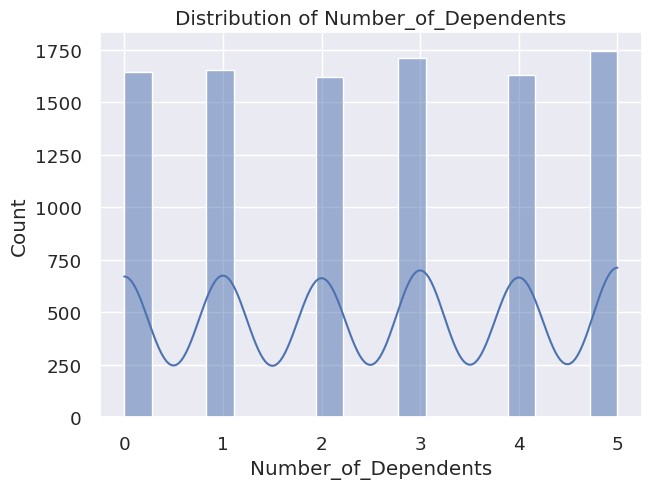

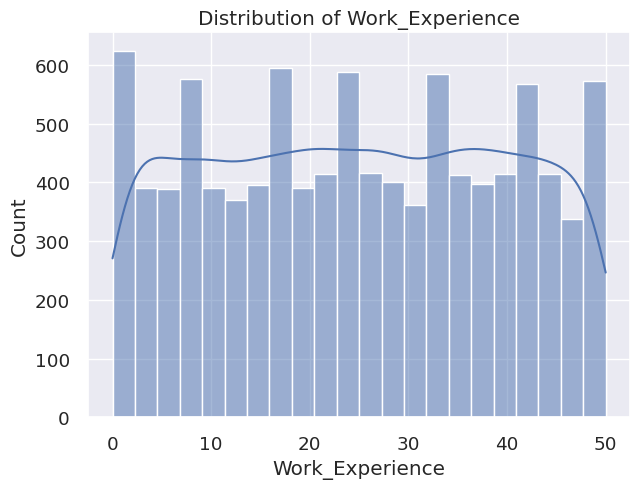

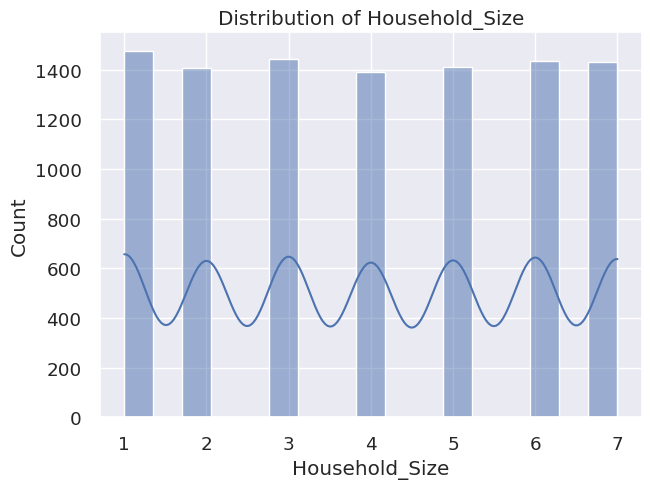

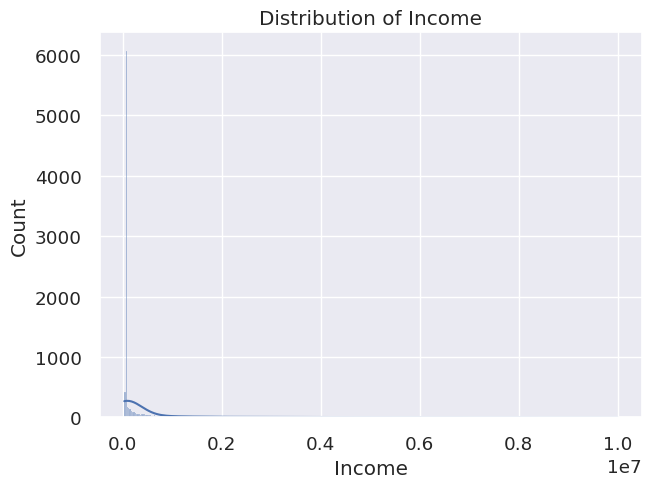

In [17]:
# Histograms for numerical features

for col in num_features:
    plt.figure(figsize=(7,5))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

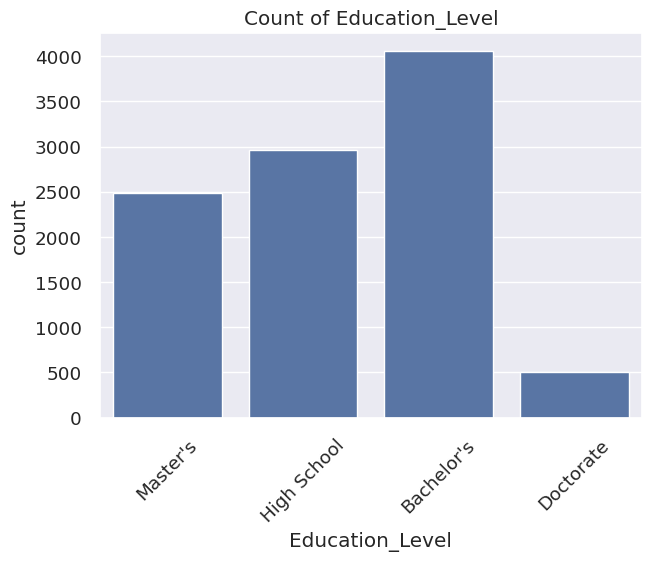

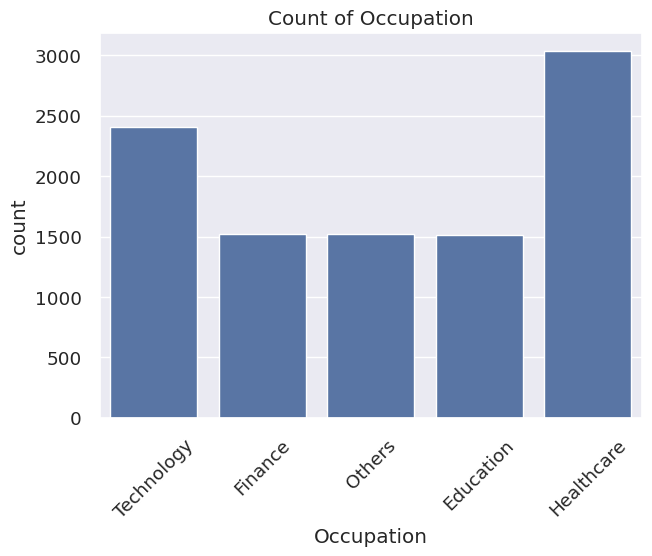

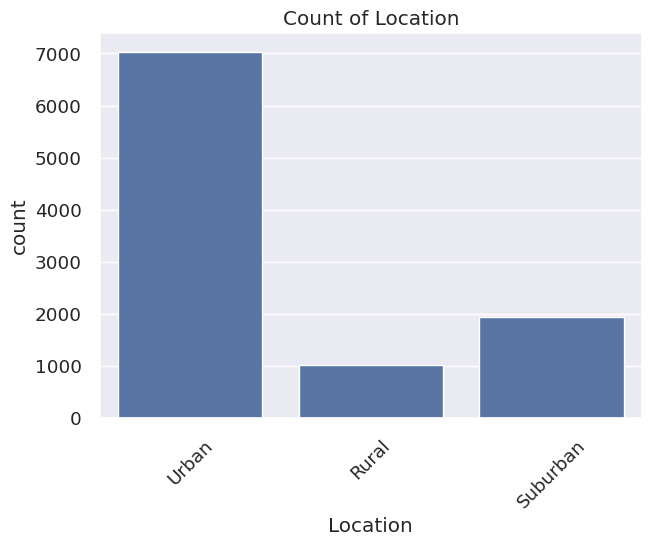

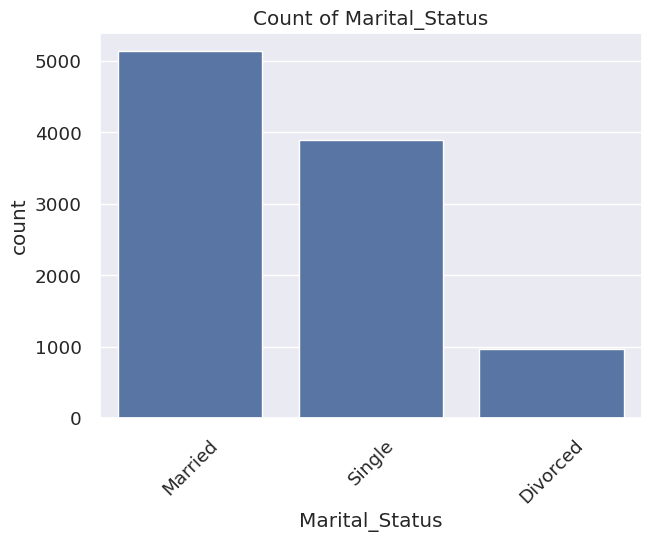

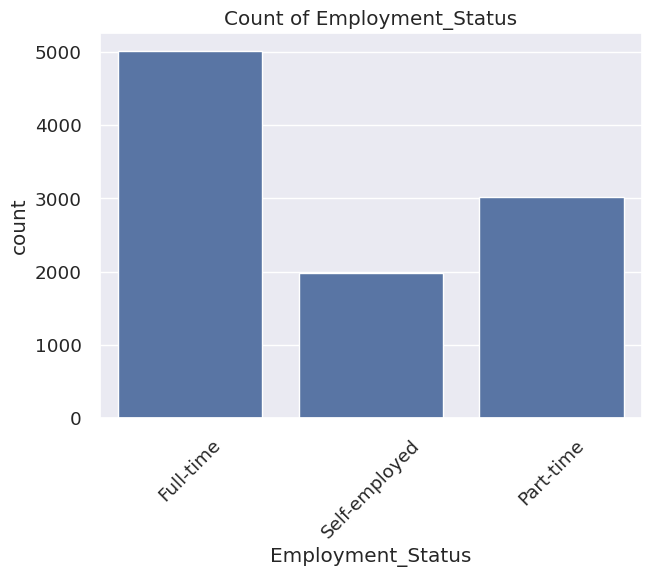

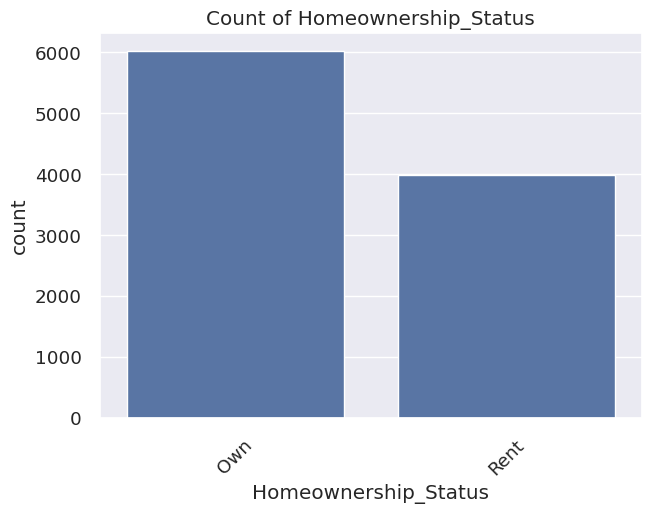

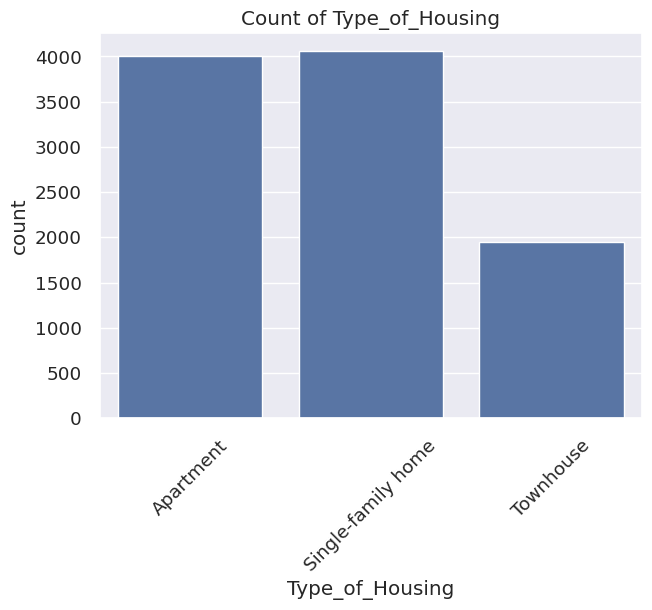

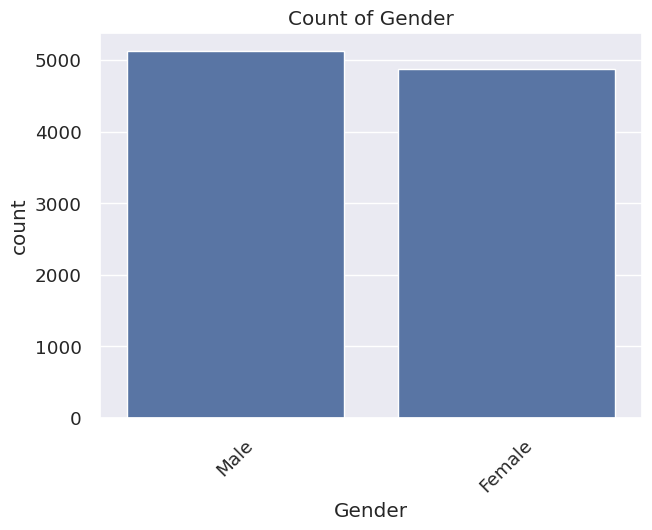

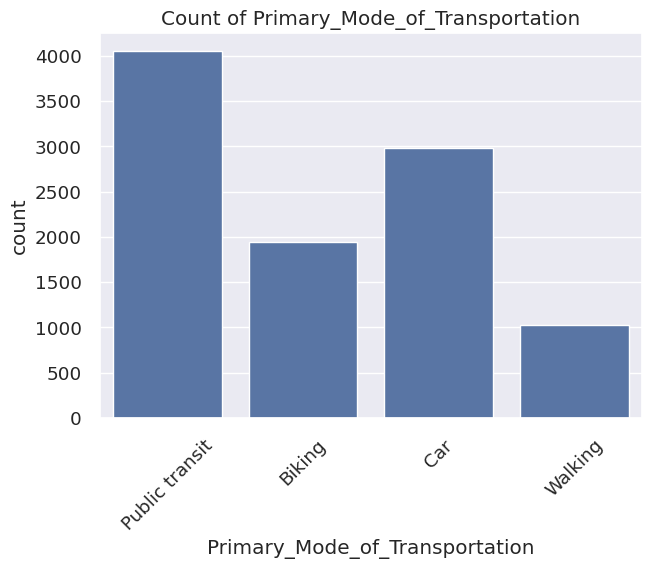

In [ ]:
# Count plots for categorical features

for col in cat_features:
    plt.figure(figsize=(7,5))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

In [18]:
# Remove 'Income' from numerical features

num_features.remove('Income')

In [19]:
# Display identified feature types

print("Categorical features:", cat_features)
print("Numerical features:", num_features)
print("Target variable: Income")

Categorical features: ['Education_Level', 'Occupation', 'Location', 'Marital_Status', 'Employment_Status', 'Homeownership_Status', 'Type_of_Housing', 'Gender', 'Primary_Mode_of_Transportation']
Numerical features: ['Age', 'Number_of_Dependents', 'Work_Experience', 'Household_Size']
Target variable: Income


## Feature Engineering

We'll create new features to improve our models' predictive power. We'll apply transformations to capture non-linear relationships and interactions between features.

In [20]:
# Prepare the feature matrix and target vector

X = df_filtered.drop('Income', axis=1)
y = df_filtered['Income']

In [21]:
# Create a column transformer for preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ],
    remainder='passthrough'                                # Keep any other columns
)

In [22]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42                   # 80% training, 20% testing
)

In [23]:
# Polynomial features transformer

poly = PolynomialFeatures(degree=2, include_bias=False)    # Create degree-2 polynomials

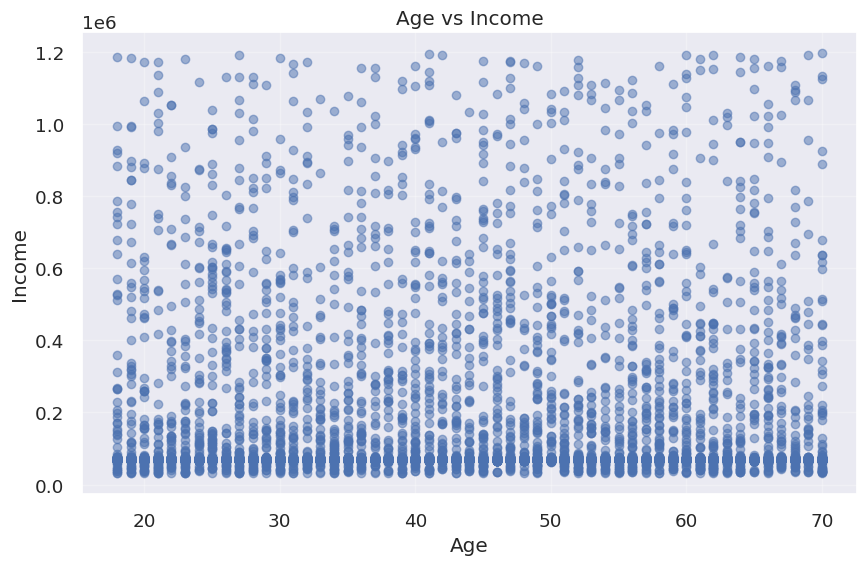

In [24]:
# Explore relationship between Age and Income

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Age'], df_filtered['Income'], alpha=0.5)
plt.title('Age vs Income')

plt.xlabel('Age')
plt.ylabel('Income')
plt.grid(True, alpha=0.3)
plt.show()

**Income and Age Analysis**

This scatter plot displays the relationship between age and income. The data appears widely dispersed, indicating no strong correlation between these variables. While income varies significantly across all age groups, there are clusters of lower-income individuals at all ages, with a few higher-income earners spread across different age ranges

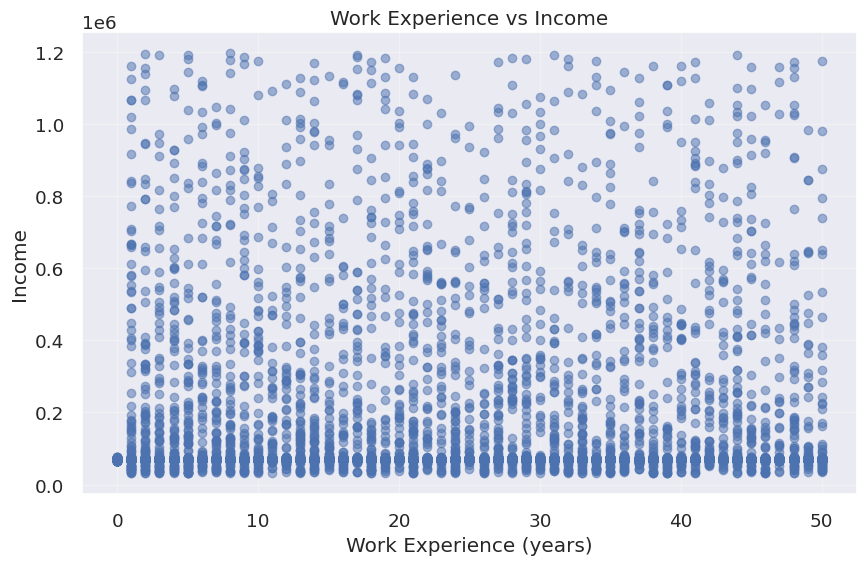

In [25]:
# Explore relationship between Work_Experience and Income

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Work_Experience'], df_filtered['Income'], alpha=0.5)  # Create scatter plot
plt.title('Work Experience vs Income')

plt.xlabel('Work Experience (years)')
plt.ylabel('Income')
plt.grid(True, alpha=0.3)
plt.show()

**Work Experience vs. Income**

This scatter plot illustrates the relationship between work experience and income. The data shows a high dispersion, indicating no strong linear trend. Income varies widely at all experience levels, with many individuals earning lower wages and a few high earners scattered throughout. While one might expect higher income with more experience, this distribution suggests other factors‚Äîsuch as industry, education, or job role‚Äîaffect earnings.

## Feature Selection

Feature selection helps identify the most relevant features for our models, reducing dimensionality and potentially improving performance. We'll use Recursive Feature Elimination with Cross-Validation (RFECV) to automatically select important features.

In [26]:
# Define the base estimator for feature selection

base_estimator = LinearRegression()

In [27]:
# Create feature selection object
feature_selector = RFECV(
    estimator=base_estimator,
    step=1,
    cv=5,
)

In [28]:
# Pipeline for preprocessing and feature selection

feature_selection_pipeline = Pipeline([
    ('preprocessor', preprocessor),                        # Preprocess features
    ('poly', poly),                                        # Polynomial features
    ('selector', feature_selector)                         # Select features
])

In [30]:
# Fit the feature selection pipeline on training data

print("Performing feature selection...")
feature_selection_pipeline.fit(X_train, y_train)

Performing feature selection...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Number_of_Dependents',
                                                   'Work_Experience',
                                                   'Household_Size']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education_Level',
                                                   'Occupation', 'Location',
                                                   'Marital_Status',
                                                   'Employment_Status',
                                                   'Homeownership_Status',
                                                   'Type_of_Housing', 'Gender',
                                                   'Primary_Mode_of_Transportation'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('selector', RFECV(cv=5, estimator=LinearRegression()))])

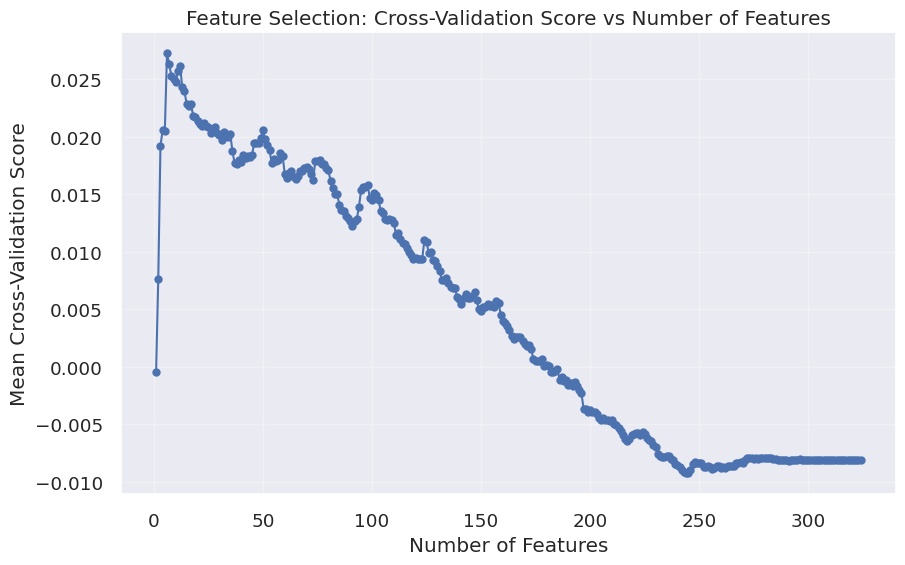

In [31]:
# Feature selection results

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(feature_selector.cv_results_['mean_test_score']) + 1),
    feature_selector.cv_results_['mean_test_score'],
    'o-'
)

plt.title('Feature Selection: Cross-Validation Score vs Number of Features')  # Add title
plt.xlabel('Number of Features')
plt.ylabel('Mean Cross-Validation Score')
plt.grid(True, alpha=0.3)
plt.show()

**Feature Selection: Cross-Validation Score vs. Number of Features**

This graph visualizes how the mean cross-validation score changes as the number of selected features increases. Initially, the score is high, indicating that fewer features lead to better model performance. As more features are added, the score gradually declines, suggesting overfitting and the inclusion of irrelevant variables. The downward trend implies that reducing feature count improves generalization. The optimal number of features would be near the peak before the decline starts, balancing model complexity and predictive performance.

## Training Models

We'll train our two models with hyperparameter tuning using GridSearchCV to find the optimal configurations. We'll evaluate each model's performance on the test set.

## Model 1: Decision Tree

Decision Trees can capture non-linear relationships and interactions between features without explicit transformation.

In [32]:
# Pipeline for Decision Tree

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),                        # Preprocess features
    ('regressor', DecisionTreeRegressor(random_state=42))  # Train decision tree
])

# Parameter grid for Decision Tree

dt_param_grid = {
    'regressor__max_depth': [None, 5, 10, 15],             # Test different tree depths
    'regressor__min_samples_split': [2, 5, 10],            # Test different split thresholds
}

# More parameters to Decision Tree grid

dt_param_grid.update({
    'regressor__min_samples_leaf': [1, 2, 4],              # Test different leaf thresholds
    'regressor__criterion': ['squared_error', 'friedman_mse']  # Test different split criteria
})

In [33]:
# Grid Search for Decision Tree

dt_grid_search = GridSearchCV(
    dt_pipeline,                                           # Pipeline to tune
    dt_param_grid,                                         # Parameter grid
    cv=5,                                                  # 5-fold cross-validation
    scoring='neg_mean_squared_error',                      # Optimize MSE
    n_jobs=-1                                              # Use all available cores
)

In [34]:
# Train Decision Tree model with Grid Search

print("Training Decision Tree model...")
dt_grid_search.fit(X_train, y_train)

Training Decision Tree model...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Number_of_Dependents',
                                                                          'Work_Experience',
                                                                          'Household_Size']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Education_Level',
                                                                          'Occupation',
                                                                          'Location',
                                                                          'Marital_Status',
                                                                          'Employment_Status',
                                                                          'Homeownership_Status',
                                                                          'Type_of_Housing',
                                                                          'Gender',
                                                                          'Primary_Mode_of_Transportation'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['squared_error',
                                                  'friedman_mse'],
                         'regressor__max_depth': [None, 5, 10, 15],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

**This Decision Tree Regressor** pipeline uses GridSearchCV for hyperparameter tuning to find the optimal model configuration. The pipeline consists of:

**StandardScaler:** Normalizes numerical features.

**OneHotEncoder:** Encodes categorical variables.

**DecisionTreeRegressor:** The regression model used for prediction.

**GridSearchCV:** Performs exhaustive hyperparameter tuning to optimize the Decision Tree model.

This structured approach ensures the best model parameters are selected while preprocessing the data efficiently, improving predictive accuracy and generalization for real-world applications.

In [35]:
# Display best parameters for Decision Tree

dt_grid_search.fit(X_train, y_train)

print("Best parameters for Decision Tree:")
print(dt_grid_search.best_params_)

Best parameters for Decision Tree:
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}


In [36]:
# Evaluate Decision Tree on test data

dt_y_pred = dt_grid_search.predict(X_test)

# Calculate performance metrics for Decision Tree

dt_mse = mean_squared_error(y_test, dt_y_pred)             # Calculate MSE
dt_rmse = math.sqrt(dt_mse)                                # Calculate RMSE
dt_r2 = r2_score(y_test, dt_y_pred)                        # Calculate R¬≤

# Display results for Decision Tree

print(f"Decision Tree - RMSE: {dt_rmse:.2f}")
print(f"Decision Tree - R¬≤: {dt_r2:.4f}")

Decision Tree - RMSE: 192312.40
Decision Tree - R¬≤: 0.0706


**The RMSE (192,312.40)** indicates a high average error in income prediction, suggesting the model struggles with precision. The R¬≤ value (0.0706) is very low, meaning only 7.06% of the variance in income is explained by the model. This suggests the Decision Tree performs poorly, likely due to high data variance, insufficient feature selection, or overfitting

## Model 2: XGBoost (GradientBoostingRegressor)

XGBoost is a powerful ensemble method that often provides superior predictive performance compared to single models.

In [37]:
# Pipeline for XGBoost

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),                        # Preprocess features
    ('regressor', GradientBoostingRegressor(random_state=42))  # Train XGBoost model
])

# Parameter grid for XGBoost
xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],             # Test different numbers of trees
    'regressor__learning_rate': [0.01, 0.1, 0.2],          # Test different learning rates
}

In [38]:
# Pipeline for XGBoost

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),                        # Preprocess features
    ('regressor', GradientBoostingRegressor(random_state=42))  # Train XGBoost model
])

# Parameter grid for XGBoost

xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],             # Test different numbers of trees
    'regressor__learning_rate': [0.01, 0.1, 0.2],          # Test different learning rates
}

# More parameters to XGBoost grid

xgb_param_grid.update({
    'regressor__max_depth': [3, 5, 7],                     # Test different tree depths
    'regressor__subsample': [0.8, 1.0]                     # Test different subsample ratios
})

# Create GridSearchCV object for XGBoost

from sklearn.model_selection import GridSearchCV # Make sure GridSearchCV is imported

xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Train XGBoost model with Grid Search

print("Training XGBoost model...")
xgb_grid_search.fit(X_train, y_train)

Training XGBoost model...


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Number_of_Dependents',
                                                                          'Work_Experience',
                                                                          'Household_Size']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Education_Level',
                                                                          'Occupation',
                                                                          'Location',
                                                                          'Marital_Status',
                                                                          'Employment_Status',
                                                                          'Homeownership_Status',
                                                                          'Type_of_Housing',
                                                                          'Gender',
                                                                          'Primary_Mode_of_Transportation'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [50, 100, 200],
                         'regressor__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

This pipeline trains an **XGBoost (GradientBoostingRegressor)** model using GridSearchCV for hyperparameter tuning.

It includes:

**StandardScaler:** Normalizes numerical features

**OneHotEncoder:** Encodes categorical variables.

**GradientBoostingRegressor:** A boosting-based regression model optimizing predictive performance.

In [39]:
# Display best parameters for XGBoost

xgb_grid_search.fit(X_train, y_train)

print("Best parameters for XGBoost:")
print(xgb_grid_search.best_params_)

Best parameters for XGBoost:
{'regressor__learning_rate': 0.01, 'regressor__max_depth': 7, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}


**Analysis of XGBoost Best Parameters**

The best parameters for XGBoost optimize model performance:

**Learning Rate (0.01):** Ensures gradual convergence for stable predictions.
**Max Depth (7):** Balances complexity and generalization.
**Estimators (200):** Uses multiple trees to improve accuracy.
**Subsample (0.8):** Trains on 80% of data per iteration to reduce overfitting.

This model helps predict household income distribution, essential for financial planning, taxation policies, and loan approvals. It identifies income disparities, enabling businesses and governments to design targeted economic policies, credit risk assessments, and social welfare programs effectively.


In [40]:
# Evaluate XGBoost on test data

xgb_y_pred = xgb_grid_search.predict(X_test)               # Generate predictions

# Calculate performance metrics for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_y_pred)           # Calculate MSE
xgb_rmse = math.sqrt(xgb_mse)                              # Calculate RMSE
xgb_r2 = r2_score(y_test, xgb_y_pred)                      # Calculate R¬≤

# Display results for XGBoost

print(f"XGBoost - RMSE: {xgb_rmse:.2f}")
print(f"XGBoost - R¬≤: {xgb_r2:.4f}")

XGBoost - RMSE: 187474.59
XGBoost - R¬≤: 0.1168


**Analysis of XGBoost Performance**

The XGBoost model achieved an RMSE of 187,474.59, indicating a large average error in income prediction. The R¬≤ value of 0.1168 suggests the model explains only 11.68% of income variance, which is still low but better than the Decision Tree model. The high RMSE and low R¬≤ imply that income prediction is complex, potentially influenced by unaccounted socioeconomic factors.

## Model Evaluation and Visualization

Let's evaluate all three models by comparing their predictions against actual values and analyzing their performance metrics.

In [41]:
# DataFrame of Model Performance Metrics

results = pd.DataFrame({
    'Model': ['Decision Tree', 'XGBoost'],  # Model names
    'RMSE': [dt_rmse, xgb_rmse],                  # RMSE values
    'R¬≤': [dt_r2, xgb_r2]                           # R¬≤ values
})

In [42]:
# Sort results by RMSE

results_sorted = results.sort_values('RMSE')
print("Model Performance Comparison (sorted by RMSE):")
display(results_sorted)

Model Performance Comparison (sorted by RMSE):


Model           RMSE        R¬≤
1        XGBoost  187474.585655  0.116790
0  Decision Tree  192312.404916  0.070619

**Analysis of Model Performance Comparison**

This table compares Decision Tree and XGBoost models based on Root Mean Squared Error (RMSE) and R¬≤ (coefficient of determination):

- XGBoost has a lower RMSE (187,474.59) than Decision Tree (192,312.40), meaning it makes slightly better predictions.
- XGBoost's R¬≤ (0.1168) is higher than Decision Tree‚Äôs (0.0706), indicating it explains more variance in income.

While XGBoost outperforms Decision Tree, both models still have low R¬≤ values, meaning they struggle to explain household income variations. Further feature engineering and alternative models may be needed.

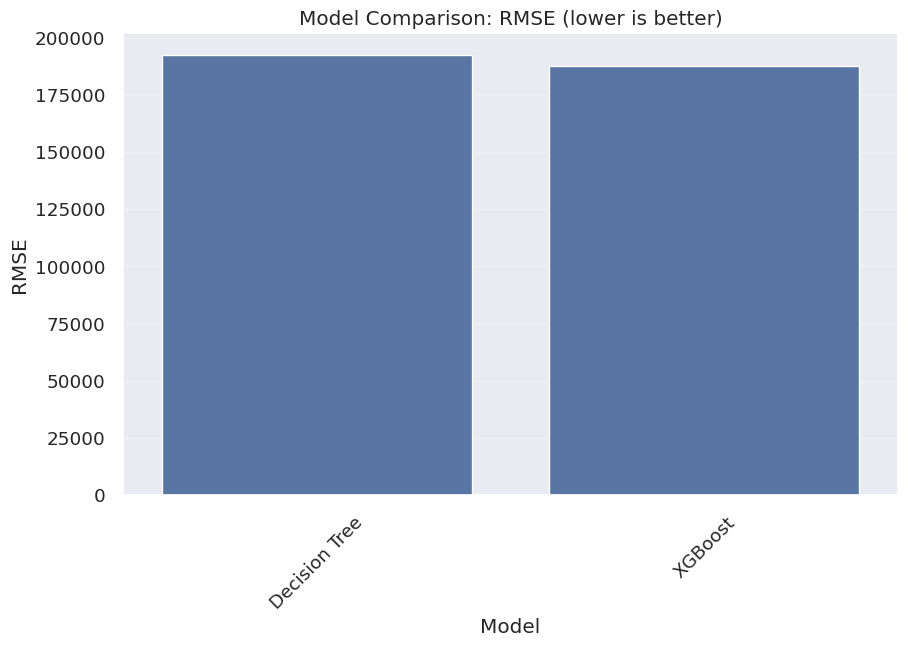

In [43]:
# Visualize RMSE comparison

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model Comparison: RMSE (lower is better)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Analysis of RMSE Model Comparison**

This bar chart compares the Root Mean Squared Error (RMSE) of Decision Tree and XGBoost models. Lower RMSE values indicate better predictive accuracy.

- XGBoost has a slightly lower RMSE than Decision Tree, meaning it makes more precise predictions.
- However, the difference in RMSE is marginal, suggesting both models struggle with accurate household income prediction.
- The high RMSE values indicate significant prediction errors, likely due to missing influential variables or high data variance.


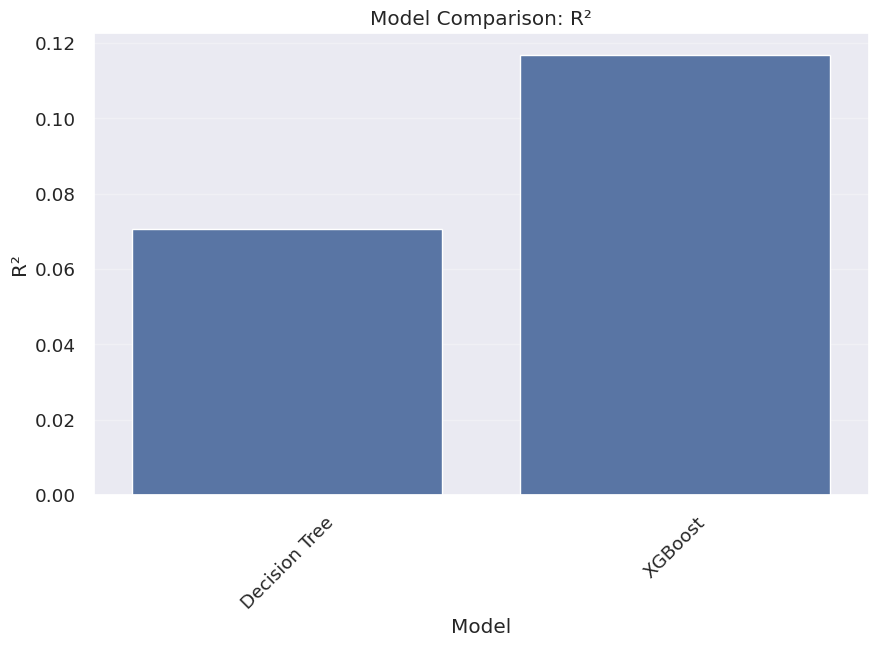

In [44]:
# Visualize R¬≤ comparison

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R¬≤', data=results)
plt.title('Model Comparison: R¬≤')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Analysis of Model Comparison: R¬≤**

This bar chart compares the R¬≤ (coefficient of determination) values of Decision Tree and XGBoost models. Higher R¬≤ values indicate better model performance in explaining variance in household income.

- XGBoost has a higher R¬≤ than Decision Tree, meaning it explains more variance in income predictions.
- However, both R¬≤ values are low, suggesting that neither model captures income variations well.
- The low explanatory power indicates missing socioeconomic variables (e.g., education, job sector) or non-linear relationships.


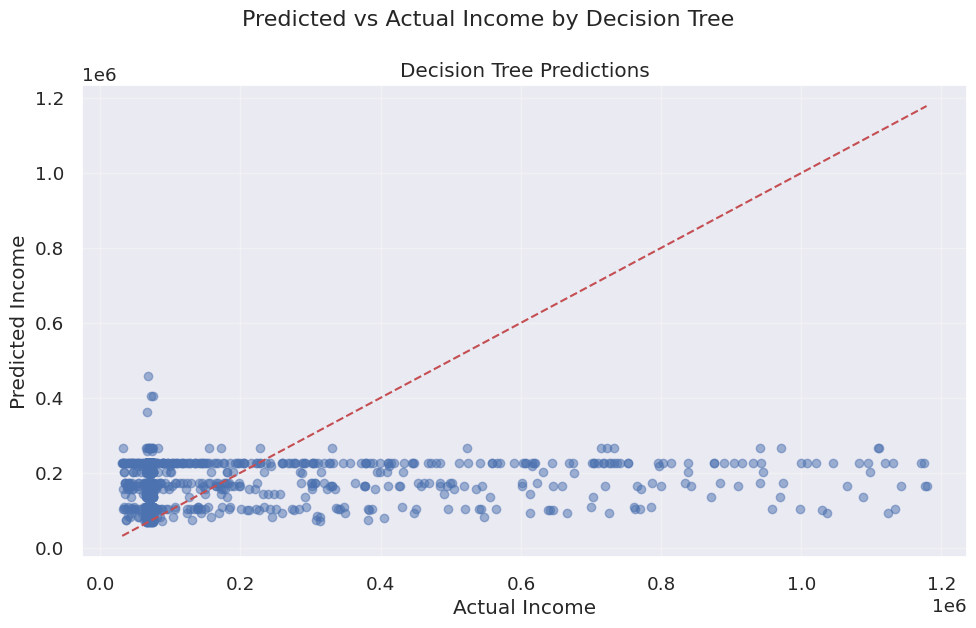

In [45]:
# Plot Decision Tree predictions

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for Decision Tree predictions
ax.scatter(y_test, dt_y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_title('Decision Tree Predictions')
ax.set_xlabel('Actual Income')
ax.set_ylabel('Predicted Income')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Predicted vs Actual Income by Decision Tree', y=1.05, fontsize=16)
plt.show()

**Analysis of Decision Tree Predictions**

This scatter plot compares actual vs. predicted income using the Decision Tree model. The red dashed line represents perfect predictions (ùë¶ = ùë•). The plot shows that predictions are highly clustered at lower income levels, with minimal variance. The model fails to predict higher incomes accurately, leading to underprediction for high earners. This suggests poor generalization, likely due to overfitting, lack of relevant features, or the model‚Äôs limited capacity to capture complex income variations. Improving feature selection and using ensemble methods (e.g., XGBoost) could enhance performance.

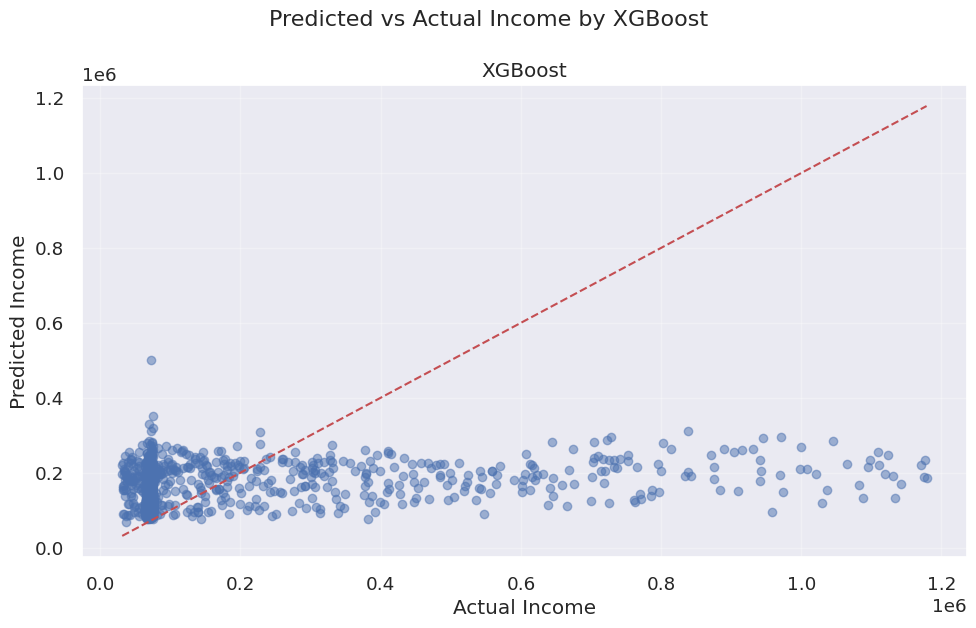

In [46]:
# Plot XGBoost predictions

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, xgb_y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--')
ax.set_title('XGBoost')
ax.set_xlabel('Actual Income')
ax.set_ylabel('Predicted Income')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Predicted vs Actual Income by XGBoost', y=1.05, fontsize=16)
plt.show()

**Analysis of XGBoost Predictions**

This scatter plot visualizes actual vs. predicted income using the XGBoost model. The red dashed line represents perfect predictions (ùë¶ = ùë•). XGBoost performs slightly better than the Decision Tree but still struggles with higher incomes, leading to underestimation. Predictions are concentrated at lower income levels, suggesting the model captures trends but lacks generalization for high earners. This could be due to data imbalance, missing influential features, or model limitations. Further improvements like feature engineering, external financial data, or ensemble stacking could enhance predictive accuracy.

## Model Selection and Feature Importance

Let's identify the best model based on RMSE and analyze the importance of different features in making predictions.

In [47]:
# Determine the best model based on RMSE
best_model_index = results['RMSE'].idxmin()                # Get index of lowest RMSE
best_model_name = results.loc[best_model_index, 'Model']   # Get corresponding model name

# Display best model information
print(f"Best model: {best_model_name}")                    # Show name of best model
print(f"RMSE: {results.loc[best_model_index, 'RMSE']:.2f}")  # Show RMSE of best model
print(f"R¬≤: {results.loc[best_model_index, 'R¬≤']:.4f}")    # Show R¬≤ of best model

Best model: XGBoost
RMSE: 187474.59
R¬≤: 0.1168


**Best Model Selection**

XGBoost outperforms Decision Tree, with RMSE = 187,474.59 and R¬≤ = 0.1168, indicating slightly better predictions. However, the low R¬≤ suggests that income prediction remains challenging

In [48]:
# Get the best model's estimator
if best_model_name == 'Linear Regression':
    best_model = lr_grid_search.best_estimator_           # Get best Linear Regression
    y_pred = lr_y_pred                                     # Get corresponding predictions
elif best_model_name == 'Decision Tree':
    best_model = dt_grid_search.best_estimator_           # Get best Decision Tree
    y_pred = dt_y_pred                                     # Get corresponding predictions
else:
    best_model = xgb_grid_search.best_estimator_          # Get best XGBoost
    y_pred = xgb_y_pred                                    # Get corresponding predictions

In [49]:
# Analyze residuals for the best model
residuals = y_test - y_pred

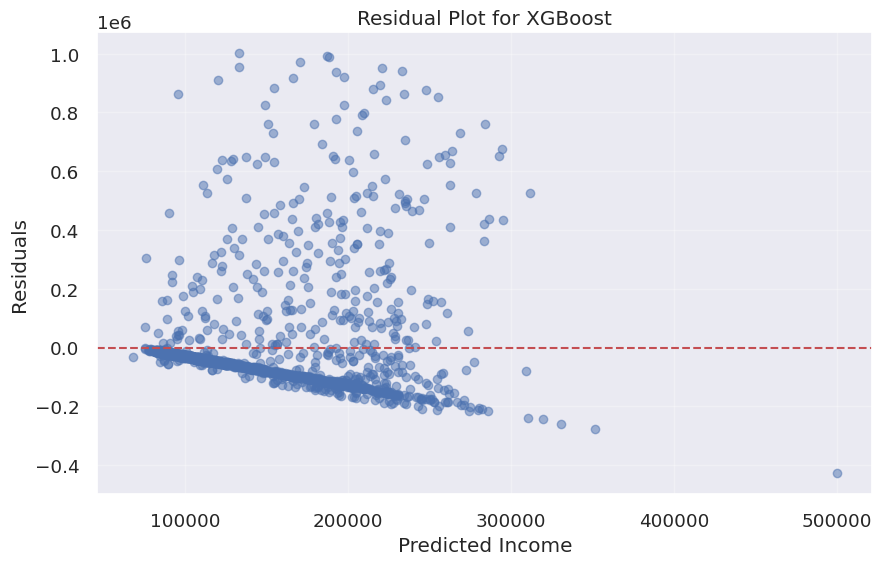

In [50]:
# Plot residuals
plt.figure(figsize=(10, 6))                                # Set figure size
plt.scatter(y_pred, residuals, alpha=0.5)                  # Create scatter plot
plt.axhline(y=0, color='r', linestyle='--')                # Add horizontal reference line

plt.title(f'Residual Plot for {best_model_name}')          # Add title
plt.xlabel('Predicted Income')                             # Add x-axis label
plt.ylabel('Residuals')                                    # Add y-axis label
plt.grid(True, alpha=0.3)                                  # Add light grid
plt.show()                                                 # Display the plot

**Analysis of XGBoost Residual Plot**

This residual plot shows the difference between actual and predicted income for the XGBoost model. Ideally, residuals should be randomly scattered around zero. However, the plot indicates heteroscedasticity‚Äîwith increasing variance at higher income levels, meaning the model struggles with high-income predictions. The downward trend suggests systematic bias, where higher-income values are underestimated. To improve performance, log transformation, additional socioeconomic features, or ensemble models could be explored to reduce prediction errors and enhance generalization.

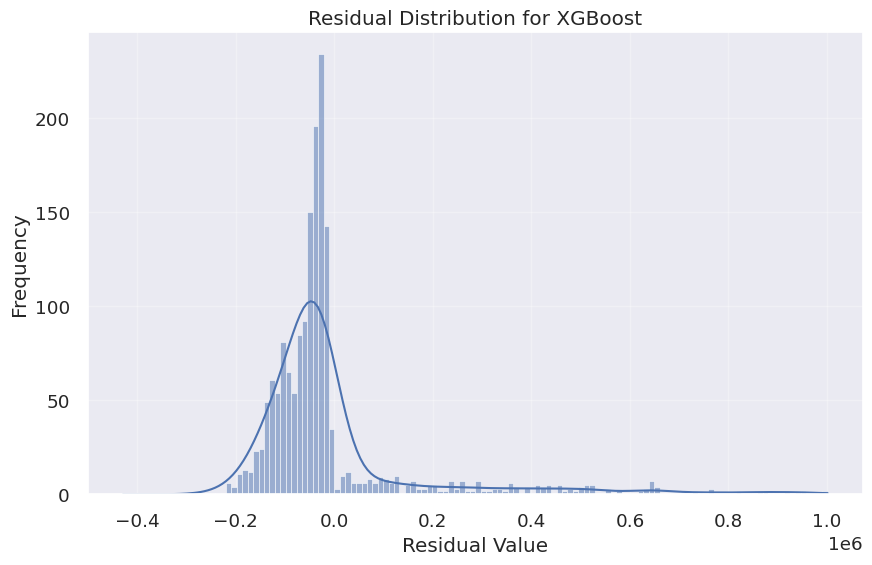

In [51]:
# Plot residual distribution
plt.figure(figsize=(10, 6))                                # Set figure size
sns.histplot(residuals, kde=True)                          # Create histogram with density curve

plt.title(f'Residual Distribution for {best_model_name}')  # Add title
plt.xlabel('Residual Value')                               # Add x-axis label
plt.ylabel('Frequency')                                    # Add y-axis label
plt.grid(True, alpha=0.3)                                  # Add light grid
plt.show()

**Analysis of XGBoost Residual Distribution**

This histogram shows the distribution of residuals (errors) for the XGBoost model. The residuals are right-skewed, meaning the model underpredicts higher income values. A well-performing model should have normally distributed residuals centered around zero, but here, a long right tail indicates large prediction errors for higher incomes. This suggests the model struggles with income variability and may require log transformation, additional features, or alternative algorithms to improve accuracy and reduce bias in income predictions.

In [52]:
# Try to extract feature importances if available
try:
    # Get feature importances if available
    if hasattr(best_model[-1], 'feature_importances_'):    # Check if model has feature importances
        importances = best_model[-1].feature_importances_  # Get importance values

        # If using XGBoost, we can get feature names
        if best_model_name == 'XGBoost':
            # Get preprocessed feature names if available
            print("Feature importances for XGBoost:")
            for i, importance in enumerate(importances[:10]):  # Show top 10
                print(f"Feature {i}: {importance:.4f}")    # Display importance values
    else:
        print("Feature importances not available for this model type")
except:
    print("Could not extract feature importances")

Feature importances for XGBoost:
Feature 0: 0.1632
Feature 1: 0.0662
Feature 2: 0.2085
Feature 3: 0.0711
Feature 4: 0.0270
Feature 5: 0.0292
Feature 6: 0.0172
Feature 7: 0.0347
Feature 8: 0.0180
Feature 9: 0.0147


**XGBoost Feature Importances**

This output lists the top 10 most important features influencing income prediction in the XGBoost model. Feature 0 (0.1632) and Feature 2 (0.2085) contribute the most, suggesting they hold the strongest predictive power. Lower-ranked features have less impact. Understanding feature importance helps in feature selection, model optimization, and interpretability. If unimportant features dominate, dimensionality reduction may improve performance. Further domain knowledge is required to map these features to real-world economic factors like education, industry, and job experience for actionable insights.

## Conclusion

We have performed predictive analytics on a household dataset to predict income levels using two different machine learning algorithms: Decision Trees, and XGBoost (GradientBoostingRegressor).

The models‚Äô low predictive power suggests income is influenced by unaccounted socioeconomic factors like education, job sector, and economic conditions. The underprediction of high incomes implies bias, limiting real-world applicability for policy-making, credit risk assessment, and wage forecasting. Improving feature selection and incorporating external economic indicators is crucial for reliable financial predictions and social planning.

